In [1]:
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset, TensorDataset
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
from tqdm import tqdm

In [2]:
class ImageCaptionDataset(Dataset):
    def __init__(self,path_images,path_caption_file,word_to_id,id_to_word,transform=None):
        super().__init__()
        self.path_images = path_images
        self.path_caption_file = path_caption_file
        self.transform = transform
        self.idxtoImageCaption= {}
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word
        with open(path_caption_file,'r') as f:
            for i,line in enumerate(f):
                image_name,caption = line.split('\t')
                tokenized_caption = self.tokenize(caption)
                self.idxtoImageCaption[i] = [image_name,tokenized_caption]

        
    def __len__(self):
        return len(self.idxtoImageCaption)
    
    def __getitem__(self,idx):
        image_name,caption = self.idxtoImageCaption[idx]
        try:
            image = Image.open(self.path_images+image_name).convert("RGB")
        except:
            return False,0,0,0
        
        if self.transform !=None:
            image = self.transform(image)

        return True,image,torch.tensor(caption),image_name
    
    def tokenize(self,caption):
        tokens = [self.word_to_id["<start>"]]
        words = caption.split()
        for word in words:
            tokens.append(self.word_to_id[word])
            
        tokens.append(self.word_to_id["<end>"])
        return tokens
            

In [3]:
path_images = '/home/student/Image_Captioning_Project/Data/Images/'
path_caption_file_train = '/home/student/Image_Captioning_Project/Data/train_captions.txt'
path_caption_file_test = '/home/student/Image_Captioning_Project/Data/test_captions.txt'
with open('/home/student/Image_Captioning_Project/Data/word_to_id.pkl','rb') as f:
    word_to_id = pickle.load(f)

with open('/home/student/Image_Captioning_Project/Data/id_to_word.pkl','rb') as f:
    id_to_word = pickle.load(f)

In [50]:
num_epochs = 6
learning_rate = 0.001
embedding_dim = 256
hidden_dim = 256
acumulate_grad_steps = 100

transform_train = transforms.Compose([transforms.Resize((200,200)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
train_dataset = ImageCaptionDataset(path_images,path_caption_file_train,word_to_id,id_to_word,transform=transform_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1, 
                                           shuffle=False)

In [51]:
def to_gpu(x):
    return x.cuda() if torch.cuda.is_available() else x

In [52]:
class CaptionGenerator(nn.Module):
    def __init__(self,vocabulary_size,embedding_dim,hidden_dim):
        super(CaptionGenerator, self).__init__()
        self.hidden_dim = hidden_dim
        self.vgg11 = models.vgg11(pretrained=True).features
        for child in self.vgg11.children():
            for param in child.parameters():
                param.requires_grad = False
        
        self.embedding = nn.Embedding(vocabulary_size,embedding_dim)
        
        self.decoder = nn.LSTM(embedding_dim,hidden_dim,batch_first=True)
        self.dense = nn.Sequential(nn.Linear(hidden_dim+512*6*6,hidden_dim),nn.ReLU(),nn.Linear(hidden_dim,vocabulary_size))
        self.criterion = nn.NLLLoss()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x,h=None,c=None):
        image,caption = x
        image_features = self.vgg11(image).view(1,512*6*6)
        embedding = None
        loss = to_gpu(torch.zeros(1).requires_grad_())
        predictions = ["<start>"]
        current_prediction = "<start>"
        if h is None:
            h= to_gpu(torch.zeros(1,1, self.hidden_dim).requires_grad_())
            c = to_gpu(torch.zeros(1,1, self.hidden_dim).requires_grad_())
            
        
        if self.training == True:
            for i in range(caption.shape[1]):
                if i ==(caption.shape[1]-1):
                    continue

                embeddings = self.embedding(caption[:,i]).view(1,1,-1)


                lstm_out,(h,c) = self.decoder(embeddings,(h,c))

                flatten = lstm_out.view(1,hidden_dim)
                cat = torch.cat([flatten,image_features],dim=1)
                probs = self.softmax(self.dense(cat))
                l = self.criterion(probs,caption[:,i+1])
                loss += l
        else:
            while current_prediction != "<end>":
                tensor = to_gpu(torch.tensor(train_dataset.word_to_id[current_prediction]))
                embeddings = self.embedding(tensor).view(1,1,-1)
                lstm_out,(h,c) = self.decoder(embeddings,(h,c))
                flatten = lstm_out.view(1,hidden_dim)
                cat = torch.cat([flatten,image_features],dim=1)
                probs = self.softmax(self.dense(cat))
                _, predicted = torch.max(probs.data, 1)
                next_word = test_dataset.id_to_word[predicted.item()]
                predictions.append(next_word)
                current_prediction = next_word

        return loss,h,c,predictions

In [53]:
model = CaptionGenerator(len(train_dataset.word_to_id),embedding_dim,hidden_dim)
model = to_gpu(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [54]:
model.train()

CaptionGenerator(
  (vgg11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

In [55]:
h = None
c = None
size = len(train_dataset)
for epoch in range(num_epochs):
    loss_train_total = 0 # To keep track of the loss value
    for i, (flag,image, caption,file) in enumerate(tqdm(train_loader)):

        if flag ==False:
            continue
            
        image = to_gpu(image)
        caption = to_gpu(caption)

        loss,h,c,predictions = model((image,caption),h,c)

        loss = loss/acumulate_grad_steps
        

        loss.backward(retain_graph=True)

        if i % acumulate_grad_steps == 0:
            optimizer.step()
            model.zero_grad()

        loss_train_total += loss.item()
        h = h.detach()
        c = h.detach()
    loss_train_total = loss_train_total / size
    print("Epoch {} Completed,\tTrain Loss: {}".format(epoch + 1, loss_train_total))

  0%|          | 3/36415 [00:00<21:20, 28.43it/s]

Epoch 1 Completed,	Train Loss: 0.5139822039827366


  0%|          | 3/36415 [00:00<21:33, 28.15it/s]

Epoch 2 Completed,	Train Loss: 0.4072807898070522


  0%|          | 3/36415 [00:00<21:31, 28.19it/s]

Epoch 3 Completed,	Train Loss: 0.3632838933608304


  0%|          | 3/36415 [00:00<21:30, 28.20it/s]

Epoch 4 Completed,	Train Loss: 0.33919274519592396


  0%|          | 3/36415 [00:00<21:38, 28.05it/s]

Epoch 5 Completed,	Train Loss: 0.3231453142930797


100%|██████████| 36415/36415 [20:45<00:00, 29.24it/s]

Epoch 6 Completed,	Train Loss: 0.30905519854540797


In [16]:
torch.save(model.state_dict(), '/home/student/Image_Captioning_Project/Training/model.pkl')

In [56]:
transform_test = transforms.Compose([transforms.Resize((200,200)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
test_dataset = ImageCaptionDataset(path_images,path_caption_file_test,word_to_id,id_to_word,transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1, 
                                           shuffle=False)

In [57]:
# model.load_state_dict(torch.load('/home/student/Image_Captioning_Project/Training/model.pkl'))
model.eval()

CaptionGenerator(
  (vgg11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

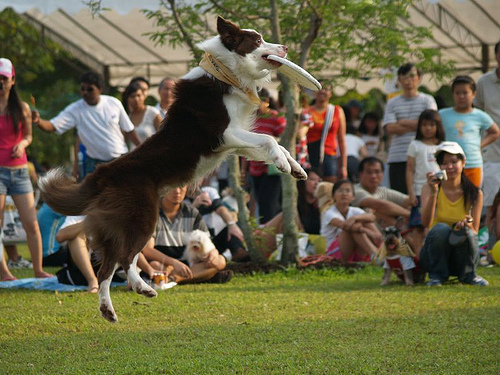

In [72]:
display(pic)

In [71]:
flag,image, caption,file = train_dataset[500]

image = to_gpu(image)
caption = to_gpu(caption)
loss,h,c,predictions = model((image.view(1,3,200,200),caption),h,c)
pic = Image.open(path_images+file)
print(predictions)
word_caption = [test_dataset.id_to_word[word.item()] for word in caption]
print(word_caption)

['<start>', 'dog', 'catches', 'frisbee', 'in', 'the', 'air', 'to', 'catch', 'frisbee', '<end>']
['<start>', 'black', 'and', 'white', 'border', 'collie', 'catches', 'frisbee', 'in', 'front', 'of', 'an', 'audience', '<end>']
